In [1]:
import matplotlib.pyplot as plt
from scipy.integrate import simps
import operator
import numpy as np
import loaders
import ML
from sklearn.metrics import roc_auc_score, accuracy_score

#plt.style.use('seaborn-dark')

In [2]:
class Item():
    def __init__(self, score, feats):
        self.score = score
        self.feats = feats

def load_file(name):
    
    items = []
    
    with open(name, 'r') as f:
        lines = f.readlines()
        
        for line in lines:

            line = line.split("'")
            score = float(line[0].replace('[', ''))
            
            feats = []
            for l in line[1:]:
                if len(l) > 2:
                    feats.append(l)
                    
                    
            items.append(Item(score, feats))
            
    return items
            
def get_feature_counts(items, lim=999, score_lim=.65, normalize=False):
    
    feat_counts = {}
    out_of = 0
    
    for item in items:
        if len(item.feats) <= lim and item.score >= score_lim:
            out_of+=1
            
            for feat in item.feats:
                
                try:
                    feat_counts[feat] += 1
                except KeyError:
                    feat_counts[feat] = 1
    
    if normalize:
        feat_counts = {ft : feat_counts[ft] / out_of for ft in feat_counts}
    
    return feat_counts, out_of

def get_weighted_feature_counts(items, lim=999, score_lim=.65, normalize=False):
    
    feat_counts = {}
    out_of = 0
    feat_count = 0
    
    for item in items:
        if len(item.feats) <= lim and item.score >= score_lim:
            out_of += item.score
            feat_count += 1
            
            for feat in item.feats:
                
                try:
                    feat_counts[feat] += item.score
                except KeyError:
                    feat_counts[feat] = item.score
    
    if normalize:
        feat_counts = {ft : feat_counts[ft] / out_of for ft in feat_counts}
    
    return feat_counts, feat_count

def proc_labels(labels):
    
    new_labels = []

    for l in labels:

        try:
            i = l.index('_')
            l = l[:i] + ' ' + l[i+1:]
        except:
            pass

        try:
            i = l.index('_')
            l = l[:i] + '\n' + l[i+1:]
        except:
            pass

        new_labels.append(l)
        
    return new_labels
    

def plot_feat_importance(feats, title, top=10, print_scores=False, save=False):
    
    #plt.style.use('seaborn-white')
    plt.figure(figsize=(top*2,10))
    
    #Sort by score
    sorted_feats = sorted(feats.items(), key=operator.itemgetter(1), reverse=True)

    inds = [i for i in range(top)]
    labels = [sorted_feats[i][0] for i in inds]
    labels = proc_labels(labels)
    
    #Plot just top #
    for i in inds:
        plt.bar(i, sorted_feats[i][1])
        
        if print_scores:
            print(labels[i], '-', sorted_feats[i][1], i+1)
        
    if max(feats.items(), key=operator.itemgetter(1))[1] <= 1:
        ylabel = 'Normalized Feature Importance'
    else:
        ylabel = 'Feature Importance'
        
    
    plt.xticks(inds, labels)
    plt.title(title, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel('Feature Name', fontsize=20)
    if save:
        plt.savefig(title + '.png', dpi=100)
    plt.show()

    
def Run_Extra_Evaluation(keys):
    all_scores = []

    #Unbalanced Sites
    sites = [1, 2, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32]

    all_preds = []
    all_test = []
    scores = []
    raw_scores = []

    for site in sites:

        (X,y), (X_test, y_test), qq, qqq = loaders.load_it_all(split_enigma=True, split_site=site, i_keys=keys)

        for q in range(1):
            model = ML.train_model(X, y, param_comb=3, classifier='log')

            preds = model.predict(X_test)
            scores.append(accuracy_score(y_test, preds))

            all_preds += list(preds)
            all_test += list(y_test)

            raw_preds = model.predict_proba(X_test)
            raw_preds = [p[1] for p in raw_preds]
            raw_scores += raw_preds

    unbalanced_micro_acc = accuracy_score(all_test, all_preds)
    unbalanced_macro_acc = np.mean(scores)
    unbalanced_min_acc = np.min(scores)
    unbalanced_micro_roc = roc_auc_score(all_test, raw_scores)

    unbalanced_avg_acc = np.mean([unbalanced_micro_acc, unbalanced_macro_acc])
    unbalanced_score = np.mean([unbalanced_avg_acc, unbalanced_min_acc, unbalanced_micro_roc])

    return unbalanced_score

def Run_Test(keys):
    
    raw_scores = []
    all_test = []
    
    sites = [2, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3, 5, 6, 7, 9]
    
    for site in sites:

        (X,y), (X_test, y_test), qq, qqq = loaders.load_it_all(split_enigma=True, split_site=site, i_keys=keys)

        for q in range(1):
            model = ML.train_model(X, y, param_comb=3, classifier='log')
            
            
            all_test += list(y_test)
            
            raw_preds = model.predict_proba(X_test)
            raw_preds = [p[1] for p in raw_preds]
            raw_scores += raw_preds
            
    all_roc = roc_auc_score(all_test, raw_scores)
    return all_roc

    
def Run_Evaluation(keys):
    all_scores = []

    #Balanced Sites
    sites = [3, 5, 6, 7, 9]

    all_preds = []
    all_test = []
    scores = []

    for site in sites:

        (X,y), (X_test, y_test), qq, qqq = loaders.load_it_all(split_enigma=True, split_site=site, i_keys=keys)

        for q in range(1):
            model = ML.train_model(X, y, classifier='log')

            preds = model.predict_proba(X_test)
            preds = [p[1] for p in preds]
            scores.append(roc_auc_score(y_test, preds))

            all_preds += list(preds)
            all_test += list(y_test)

    balanced_micro_roc = roc_auc_score(all_test, all_preds)
    balanced_macro_roc = np.mean(scores)
    balanced_min_roc = np.min(scores)

    balanced_avg_roc = np.mean([balanced_micro_roc, balanced_macro_roc])
    balanced_score = np.mean([balanced_avg_roc, balanced_min_roc])

    return balanced_macro_roc, balanced_score, Run_Test(keys)
    
def get_scores(labels, eval_type=0):
    All_Scores = []

    for qq in range(1, len(labels)):

        i_crop = labels[:qq]
        scores = Run_Evaluation(i_crop)
        
        All_Scores.append(scores[eval_type])
        
    return All_Scores

def get_top_scores(file_name, score_lim, eval_type=0, top=20):
    
    items = load_file('Key_Sets/' + file_name)
    fc, out_of = get_weighted_feature_counts(items, score_lim=score_lim, normalize=True)
    
    sorted_feats = sorted(fc.items(), key=operator.itemgetter(1), reverse=True)
    inds = [i for i in range(top)]
    labels = [sorted_feats[i][0] for i in inds]
    
    print('Score lim:', score_lim)
    #print('Feats: ', labels)
    
    scores = get_scores(labels, eval_type=eval_type)
    print('Max Score: ', max(scores))
    
    print('AUC: ', simps(scores, dx=1))
    return scores
    

def plot_scores(All_Scores):
    plt.figure(figsize=(10,5))
    plt.bar(range(1,len(All_Scores)+1), All_Scores)
    plt.ylim(.5, 1)
    plt.title('Logistic CV w/ variable # of top weighted features - initial threshold = ' + str(score_lim))
    plt.xlabel('Num. Features')
    plt.ylabel('Average ROC AUC')
    plt.show()

Analysis is between 3 different loss functions and two evolutionary search schemes

Short vs. Long Evolutionary runs, where long also features a larger population size

The loss variants are restrained and simmilar in that they each only consider the 5 sites with a mix of controls and cases as validation.

Loss 1: Size Constraint + Macro Roc Mean
Loss 2: Min Macro Roc + Macro Roc Mean
Loss 3: Size Constraint + ((Macro Roc Mean + Micro Roc Mean)/2 + Min Macro Roc)/2

Important to note that keys from loss 1,2 have the Macro Roc Mean saved with each key, and keys from loss 3 instead have the Loss 3 avg score - which makes them slightly difficult to directly compare. For this post-hoc analysis I will consider both of these scores.

**First: compare the three different losses with the shorter, more rigerously the 'same' ev search params.**

Looking at just the top 10 features when the size constraint is set such that ~200 feature sets remain

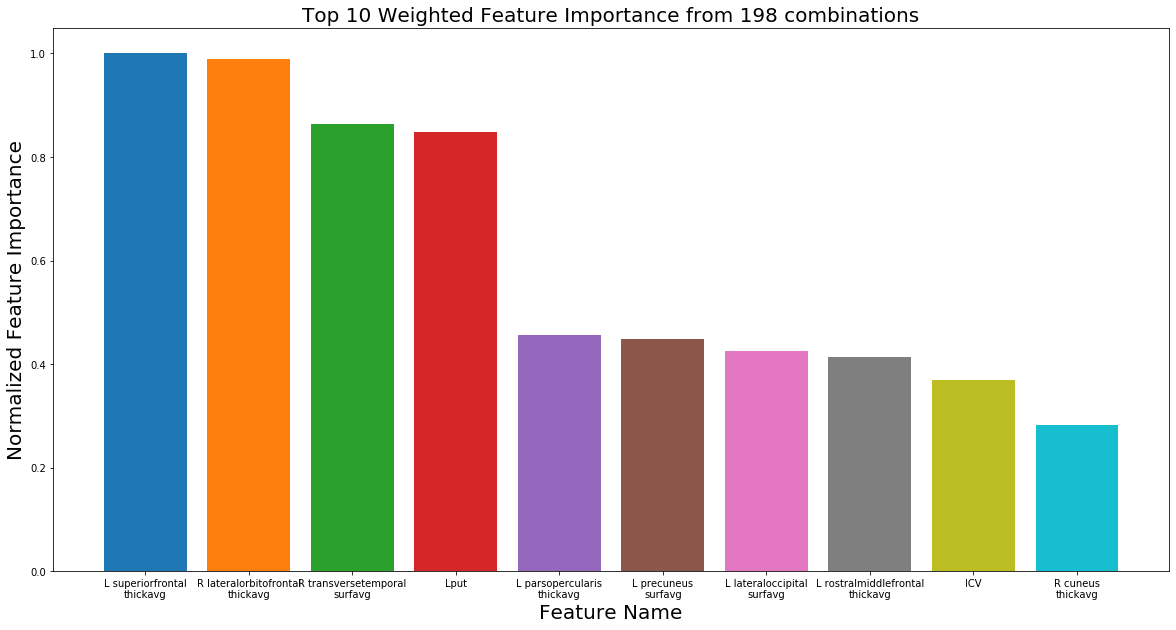

['L_lateraloccipital_surfavg', 'L_postcentral_surfavg', 'L_precuneus_surfavg', 'L_rostralmiddlefrontal_thickavg', 'L_superiorfrontal_thickavg', 'Lput', 'R_cuneus_thickavg', 'R_lateralorbitofrontal_thickavg', 'R_transversetemporal_surfavg']


In [3]:
items = load_file('Key_Sets/Loss1_Short')

fc, out_of = get_weighted_feature_counts(items, score_lim=.792, normalize=True)
top = 10
plot_feat_importance(fc, 'Top ' + str(top) + ' Weighted Feature Importance from ' + str(out_of) + ' combinations', top, False)

top_score = max([(item.score, item.feats)for item in items])
print(top_score[1])
Run_Evaluation(top_score[1])

fc1 = fc

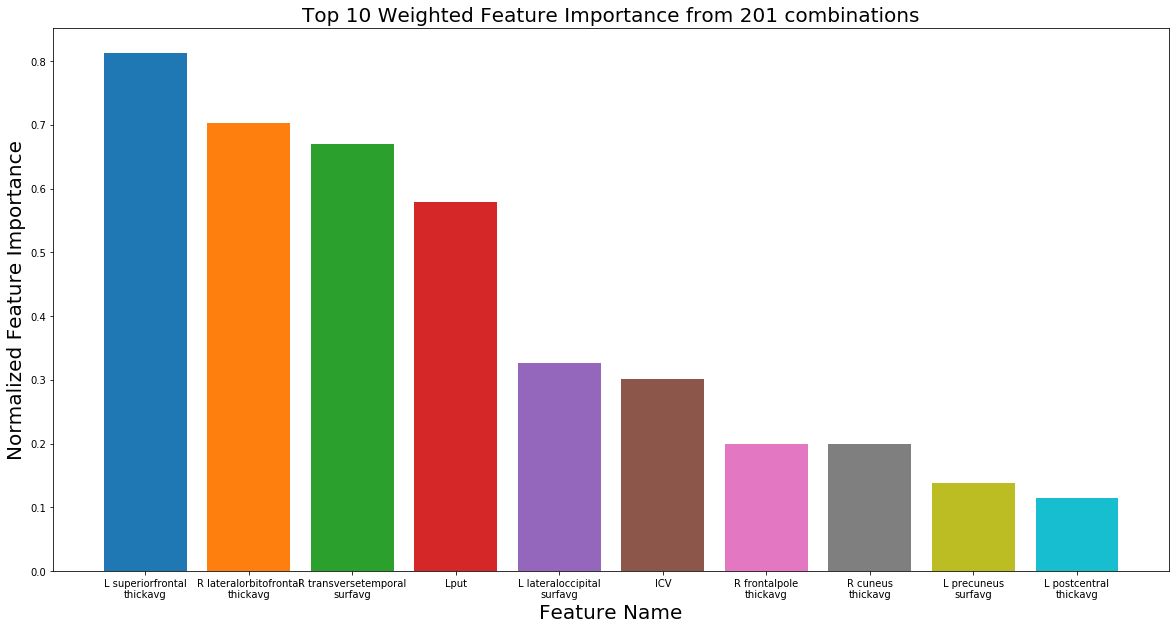

['ICV', 'L_inferiorparietal_thickavg', 'L_lateraloccipital_surfavg', 'L_parsopercularis_thickavg', 'L_superiorfrontal_thickavg', 'Lput', 'R_lateralorbitofrontal_thickavg']


In [4]:
items = load_file('Key_Sets/Loss2_Short')

fc, out_of = get_weighted_feature_counts(items, score_lim=.7575, normalize=True)
top = 10
plot_feat_importance(fc, 'Top ' + str(top) + ' Weighted Feature Importance from ' + str(out_of) + ' combinations', top, False)

top_score = max([(item.score, item.feats)for item in items])
print(top_score[1])
Run_Evaluation(top_score[1])

fc2 = fc

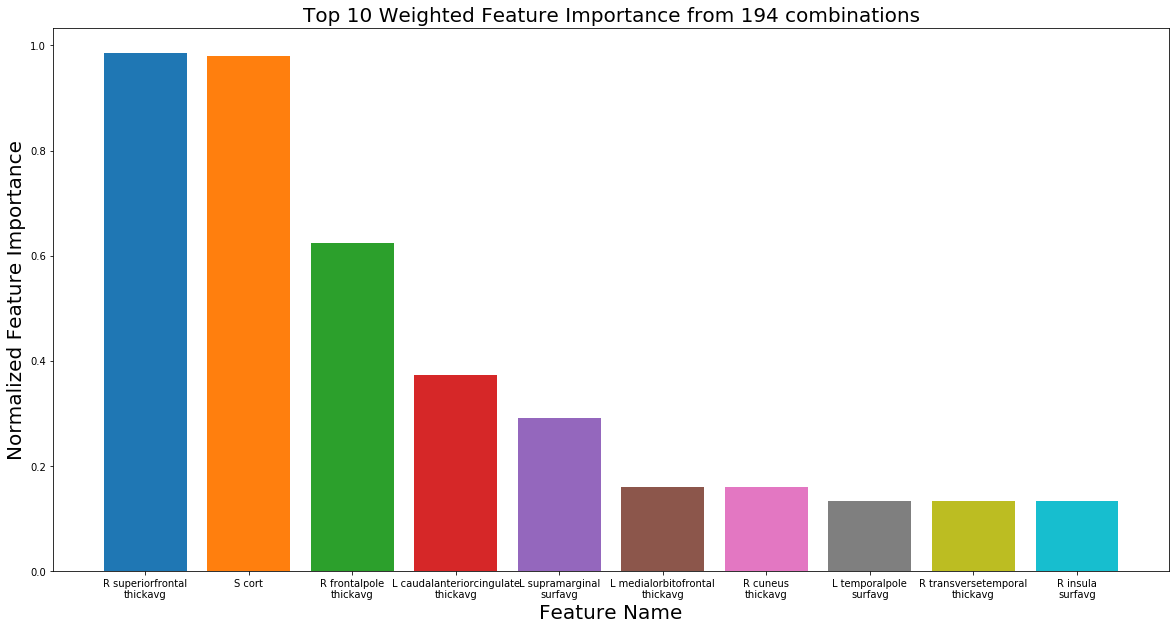

['L_caudalanteriorcingulate_thickavg', 'R_frontalpole_thickavg', 'R_lingual_surfavg', 'R_medialorbitofrontal_surfavg', 'R_superiorfrontal_thickavg', 'S_cort']


(0.7377032444473298, 0.7188565211203868, 0.7956564153439154)

In [5]:
items = load_file('Key_Sets/Removed3_Short')

fc, out_of = get_weighted_feature_counts(items, score_lim=.695, normalize=True)
#fc, out_of = get_weighted_feature_counts(items, score_lim=.738, normalize=True)
top = 10
plot_feat_importance(fc, 'Top ' + str(top) + ' Weighted Feature Importance from ' + str(out_of) + ' combinations', top, False)

top_score = max([(item.score, item.feats)for item in items])
print(top_score[1])
Run_Evaluation(top_score[1])

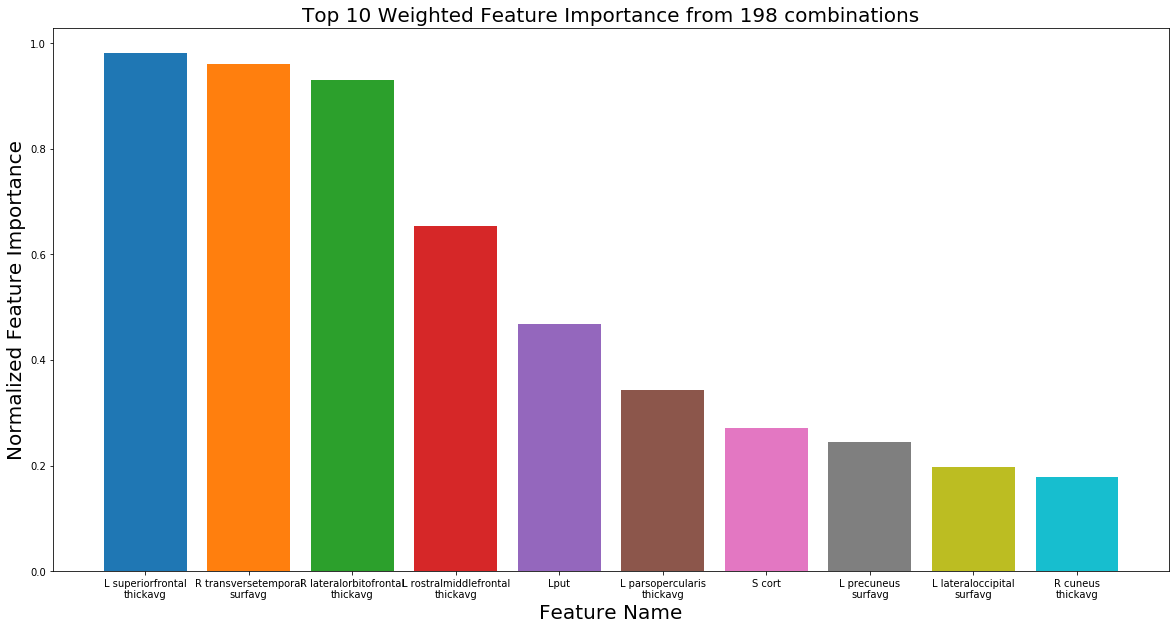

['L_lateraloccipital_surfavg', 'L_parsorbitalis_thickavg', 'L_precuneus_surfavg', 'L_rostralmiddlefrontal_thickavg', 'L_superiorfrontal_thickavg', 'Lput', 'R_inferiorparietal_surfavg', 'R_lateralorbitofrontal_thickavg', 'R_posteriorcingulate_surfavg', 'R_transversetemporal_surfavg']


In [6]:
items = load_file('Key_Sets/Loss3_Short')

#fc, out_of = get_weighted_feature_counts(items, score_lim=.76, normalize=True)
fc, out_of = get_weighted_feature_counts(items, score_lim=.737237, normalize=True)
top = 10
plot_feat_importance(fc, 'Top ' + str(top) + ' Weighted Feature Importance from ' + str(out_of) + ' combinations', top, False)

top_score = max([(item.score, item.feats)for item in items])
print(top_score[1])
Run_Evaluation(top_score[1])
fc3 = fc

Loss 1 and 2 appear to be more simmilar and not all that different to loss 3 in regard to the top features which are popping out, but loss 3 does look more different.

The next step will be the evaluate them more quanitatively in regards to both of the different evaluation metrics.

In [7]:
def plot_top_scores(key_file, eval_type, score_lims, top=21):
    
    for score_lim in score_lims:
        plt.plot(range(1, top), get_top_scores(key_file, score_lim, eval_type, top), label='Threshold = ' + str(score_lim))

    plt.legend()
    plt.title('Top Feature Analysis for ' + str(key_file) + ' on 5 balanced validation sites')
    plt.xlabel('Number of top features')

    if eval_type == 0:
        plt.ylabel('Mean Macro Roc')
    elif eval_type == 1:
        plt.ylabel('Comb. Roc Score')

    plt.show()

Method of choosing threshold for top features~ as trying various thresholds for top 20 and comparing ROC,

In [8]:
#for score_lim in np.arange(.76, .75, .001):
#    get_top_scores('Loss3_Short', score_lim, 1, 21)

In [9]:
#plot_top_scores('Loss3_Short', 1, [.76])

In [10]:
#plot_top_scores('Loss1_Short', 0, [.7, .73, .76, .79, .8])

In [11]:
#plot_top_scores('Loss2_Short', 0, [.7, .72, .74, .75, .76])

In [12]:
#plot_top_scores('Loss3_Short', 0, [.68, .7, .725, .74, .75])

With alt metric now

In [13]:
#plot_top_scores('Loss1_Short', 1, [.7, .73, .76, .79, .8])

In [14]:
#plot_top_scores('Loss2_Short', 1, [.7, .72, .74, .75, .76])

In [15]:
#plot_top_scores('Loss3_Short', 1, [.68, .7, .725, .74, .75])

Okay- so loss 3 actually seems to work better on both evaluating metrics, yielding a top score of .832 on the mean macro roc and a score of .777 on the combined metric. Interestingly, the top average macro roc from the first loss scored .821 and only .796 for the 2nd loss and the 3rd loss gave .780 - so in summary a key found in the third loss did better then any found in the post-analysis (atleast for the combined metric).

Loss 3 seems to be the clear winner in regards to the short evolutionary search, it remains to be seen if this holds for the longer version. Additionally, it is unclear if the post-hoc analysis is any better then just a key set found via the search, within the short version it would appear not.

** We can now look at the longer searches **

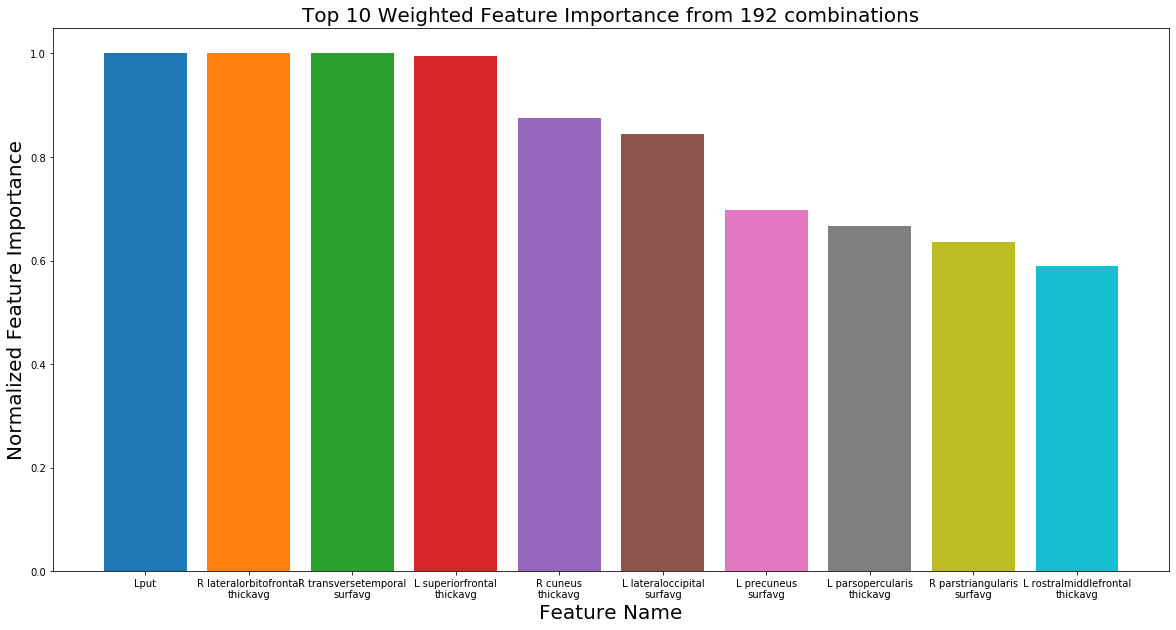

['L_lateraloccipital_surfavg', 'L_parsopercularis_thickavg', 'L_postcentral_surfavg', 'L_posteriorcingulate_thickavg', 'L_precentral_surfavg', 'L_precuneus_surfavg', 'L_rostralmiddlefrontal_thickavg', 'L_superiorfrontal_thickavg', 'L_temporalpole_surfavg', 'Lput', 'R_caudalanteriorcingulate_surfavg', 'R_cuneus_thickavg', 'R_fusiform_surfavg', 'R_lateralorbitofrontal_thickavg', 'R_parahippocampal_surfavg', 'R_parstriangularis_surfavg', 'R_precuneus_surfavg', 'R_transversetemporal_surfavg']


In [16]:
items = load_file('Key_Sets/Loss1_Long')

fc, out_of = get_weighted_feature_counts(items, score_lim=.825, normalize=True)
top = 10
plot_feat_importance(fc, 'Top ' + str(top) + ' Weighted Feature Importance from ' + str(out_of) + ' combinations', top, False)

top_score = max([(item.score, item.feats)for item in items])
print(top_score[1])
Run_Evaluation(top_score[1])

fc4 = fc

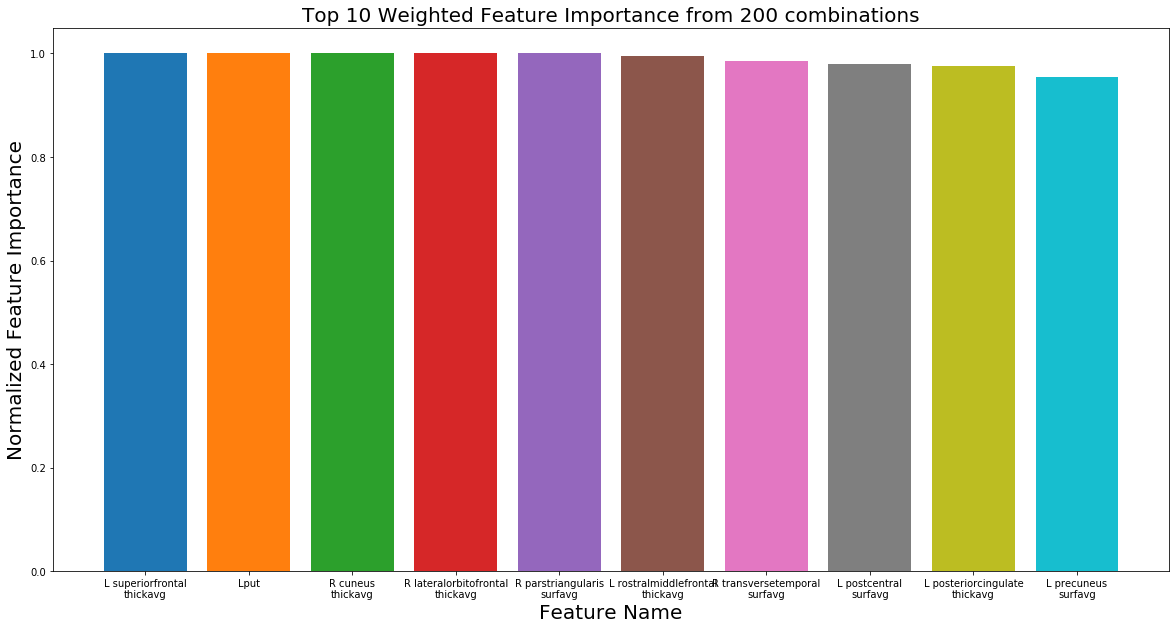

['L_isthmuscingulate_surfavg', 'L_parsopercularis_thickavg', 'L_postcentral_surfavg', 'L_posteriorcingulate_thickavg', 'L_precuneus_surfavg', 'L_rostralmiddlefrontal_thickavg', 'L_superiorfrontal_thickavg', 'L_temporalpole_surfavg', 'L_transversetemporal_surfavg', 'Lput', 'R_caudalanteriorcingulate_surfavg', 'R_cuneus_thickavg', 'R_lateraloccipital_surfavg', 'R_lateralorbitofrontal_thickavg', 'R_parahippocampal_surfavg', 'R_parstriangularis_surfavg', 'R_postcentral_surfavg', 'R_posteriorcingulate_surfavg', 'R_precuneus_surfavg', 'R_supramarginal_surfavg', 'R_transversetemporal_surfavg']


In [17]:
items = load_file('Key_Sets/Loss2_Long')

fc, out_of = get_weighted_feature_counts(items, score_lim=.849, normalize=True)
top = 10
plot_feat_importance(fc, 'Top ' + str(top) + ' Weighted Feature Importance from ' + str(out_of) + ' combinations', top, False)

top_score = max([(item.score, item.feats)for item in items])
print(top_score[1])
Run_Evaluation(top_score[1])

fc5 = fc

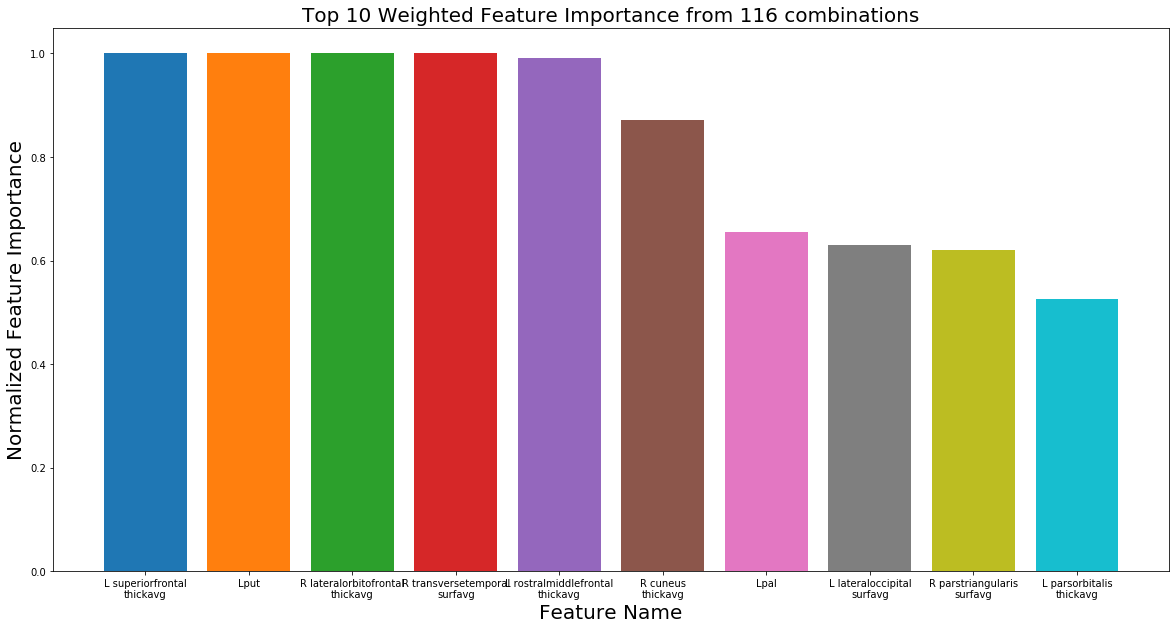

['L_lateraloccipital_surfavg', 'L_paracentral_surfavg', 'L_parsorbitalis_thickavg', 'L_posteriorcingulate_thickavg', 'L_rostralmiddlefrontal_thickavg', 'L_superiorfrontal_thickavg', 'Lpal', 'Lput', 'R_cuneus_thickavg', 'R_lateralorbitofrontal_thickavg', 'R_parsopercularis_thickavg', 'R_parstriangularis_surfavg', 'R_superiorfrontal_surfavg', 'R_transversetemporal_surfavg']


In [18]:
items = load_file('Key_Sets/Loss3_Long')

fc, out_of = get_weighted_feature_counts(items, score_lim=.787, normalize=True)
top = 10
plot_feat_importance(fc, 'Top ' + str(top) + ' Weighted Feature Importance from ' + str(out_of) + ' combinations', top, False)

top_score = max([(item.score, item.feats)for item in items])
print(top_score[1])
Run_Evaluation(top_score[1])

fc6 = fc

Very different top 10 behavior then before with the shorter version. Some similar top ten features, but especially with the second non-size constraint loss it is clear that the best preforming sets are very large! There is clearly a boost to preformance though, with top found key sets scoring .85 for loss 1 and .86 for loss 2.

In [19]:
#plot_top_scores('Loss1_Long', 0, [.79, .81, .82, .83, .835], top=30)

In [20]:
#plot_top_scores('Loss2_Long', 0, [.8, .83, .84, .85, .855], top=30)

In [21]:
#plot_top_scores('Loss3_Long', 0, [.72, .76, .78, .785, .79], top=30)

And with alt metric

In [22]:
#plot_top_scores('Loss1_Long', 1, [.79, .8, .81, .82, .83], top=30)

In [23]:
#plot_top_scores('Loss2_Long', 1, [.8, .83, .84, .85, .855], top=30)

In [24]:
#plot_top_scores('Loss3_Long', 1, [.72, .76, .78, .785, .79], top=30)

Intersting, so like before in the short version, the best found under each metric came from the search directly. The difference in the long run is that the best set of keys found by the second more comprehensive evaluation does not also evaluate with the first metric better then any found. 

It also seems that the first two loss function benefited more from the extra time going from
Loss 1: (0.8210337661178846, 0.7701848691679412) to (0.8525106210523216, 0.7714493085295537)
Loss 2: (0.7961594323436535, 0.7507383183083256) to (0.8618395629483956, 0.7910524031298868)
Loss 3: (0.8049470131265919, 0.7797205000737779) to (0.819451719280505, 0.8009557441913837)

Looking explictily at these 'best' found sets of keys, two potential canidates emerge,
the best found set of keys from loss2 long and from loss 3 long. They respectively constitute the best under each evaluation metric. Loss 2, while doing well on both metrics also contains many more keys, which lends support to using just the keys from Loss 3... 

Of course the real problem here is that in both cases I am essentially choosing a model from the validation set that was already used, in this sense it is very possible that I am overfitting - especially with the longer searches. Given this, perhaps it makes sense to evaluate the top results using the 'Extra' information... 

Specifically, we can take the top key sets found from the different losses and search lengths and preform model selection using the micro roc auc from not just the 5 validation sites but all of the unbalanced sites (with the exception of site 1, as removing ~half of the positive samples is bound to have a deterious effect). 

Two more hypothesis: 
-Use this selection criterea across all of the different models
-Do an evolutionary search specifically for this selection criteria

In [25]:
#loss3_long = ['L_lateraloccipital_surfavg', 'L_paracentral_surfavg', 'L_parsorbitalis_thickavg', 'L_posteriorcingulate_thickavg', 'L_rostralmiddlefrontal_thickavg', 'L_superiorfrontal_thickavg', 'Lpal', 'Lput', 'R_cuneus_thickavg', 'R_lateralorbitofrontal_thickavg', 'R_parsopercularis_thickavg', 'R_parstriangularis_surfavg', 'R_superiorfrontal_surfavg', 'R_transversetemporal_surfavg']
#loss2_long = ['L_isthmuscingulate_surfavg', 'L_parsopercularis_thickavg', 'L_postcentral_surfavg', 'L_posteriorcingulate_thickavg', 'L_precuneus_surfavg', 'L_rostralmiddlefrontal_thickavg', 'L_superiorfrontal_thickavg', 'L_temporalpole_surfavg', 'L_transversetemporal_surfavg', 'Lput', 'R_caudalanteriorcingulate_surfavg', 'R_cuneus_thickavg', 'R_lateraloccipital_surfavg', 'R_lateralorbitofrontal_thickavg', 'R_parahippocampal_surfavg', 'R_parstriangularis_surfavg', 'R_postcentral_surfavg', 'R_posteriorcingulate_surfavg', 'R_precuneus_surfavg', 'R_supramarginal_surfavg', 'R_transversetemporal_surfavg']
#loss1_long = ['L_lateraloccipital_surfavg', 'L_parsopercularis_thickavg', 'L_postcentral_surfavg', 'L_posteriorcingulate_thickavg', 'L_precentral_surfavg', 'L_precuneus_surfavg', 'L_rostralmiddlefrontal_thickavg', 'L_superiorfrontal_thickavg', 'L_temporalpole_surfavg', 'Lput', 'R_caudalanteriorcingulate_surfavg', 'R_cuneus_thickavg', 'R_fusiform_surfavg', 'R_lateralorbitofrontal_thickavg', 'R_parahippocampal_surfavg', 'R_parstriangularis_surfavg', 'R_precuneus_surfavg', 'R_transversetemporal_surfavg']

#loss3_short = ['L_lateraloccipital_surfavg', 'L_parsorbitalis_thickavg', 'L_precuneus_surfavg', 'L_rostralmiddlefrontal_thickavg', 'L_superiorfrontal_thickavg', 'Lput', 'R_inferiorparietal_surfavg', 'R_lateralorbitofrontal_thickavg', 'R_posteriorcingulate_surfavg', 'R_transversetemporal_surfavg']
#loss2_short = ['ICV', 'L_inferiorparietal_thickavg', 'L_lateraloccipital_surfavg', 'L_parsopercularis_thickavg', 'L_superiorfrontal_thickavg', 'Lput', 'R_lateralorbitofrontal_thickavg']
#loss1_short = ['L_lateraloccipital_surfavg', 'L_postcentral_surfavg', 'L_precuneus_surfavg', 'L_rostralmiddlefrontal_thickavg', 'L_superiorfrontal_thickavg', 'Lput', 'R_cuneus_thickavg', 'R_lateralorbitofrontal_thickavg', 'R_transversetemporal_surfavg']

In [26]:
#print(Run_Evaluation(['L_superiorfrontal_thickavg', 'Lput', 'R_lateralorbitofrontal_thickavg','R_transversetemporal_surfavg'])[2])

In [27]:
#print(Run_Evaluation(loss3_long)[2])
#print(Run_Evaluation(loss2_long)[2])
#print(Run_Evaluation(loss1_long)[2])
#print(Run_Evaluation(loss3_short)[2])
#print(Run_Evaluation(loss2_short)[2])
#print(Run_Evaluation(loss1_short)[2])

In [28]:
#len(['L_lateraloccipital_surfavg', 'L_parsorbitalis_thickavg', 'L_precuneus_surfavg', 'L_rostralmiddlefrontal_thickavg', 'L_superiorfrontal_thickavg', 'Lput', 'R_inferiorparietal_surfavg', 'R_lateralorbitofrontal_thickavg', 'R_posteriorcingulate_surfavg', 'R_transversetemporal_surfavg'])

In [29]:
from collections import Counter

fc1 = Counter(fc1)
fc2 = Counter(fc2)
fc3 = Counter(fc3)
fc4 = Counter(fc4)
fc5 = Counter(fc5)
fc6 = Counter(fc6)

fc = fc1 + fc2 + fc3 + fc4 + fc5 + fc6

for key in fc:
    fc[key] = fc[key] / 6

In [30]:
def plot_feat_importance(feats, title, top=10, print_scores=False, save=False):
    
    #plt.style.use('seaborn-dark')
    plt.figure(figsize=(top*2,10))
    
    #Sort by score
    sorted_feats = sorted(feats.items(), key=operator.itemgetter(1), reverse=True)

    inds = [i for i in range(top)]
    labels = [sorted_feats[i][0] for i in inds]
    labels = proc_labels(labels)
    
    #Plot just top #
    for i in inds:
        plt.bar(i, sorted_feats[i][1])
        
        if print_scores:
            print(labels[i], '-', sorted_feats[i][1], i+1)
        
    if max(feats.items(), key=operator.itemgetter(1))[1] <= 1:
        ylabel = 'Normalized Feature Importance'
    else:
        ylabel = 'Feature Importance'
        
    
    plt.xticks(inds, labels, fontsize=11)
    plt.title(title, fontsize=30)
    plt.ylabel(ylabel, fontsize=27)
    plt.xlabel('Feature Name', fontsize=27)
    
    plt.savefig(title + '.png', dpi=100, transparent=True)
    plt.show()

L superiorfrontal
thickavg - 0.9644287070992464 1
R lateralorbitofrontal
thickavg - 0.9370724638218798 2
R transversetemporal
surfavg - 0.9130556780480584 3
Lput - 0.8156844032135625 4
L rostralmiddlefrontal
thickavg - 0.6220669671585163 5
R cuneus
thickavg - 0.5677746127674497 6
L lateraloccipital
surfavg - 0.525918250598898 7
L precuneus
surfavg - 0.4916882646715655 8
L parsopercularis
thickavg - 0.41473515234900143 9
R parstriangularis
surfavg - 0.4142181243747405 10


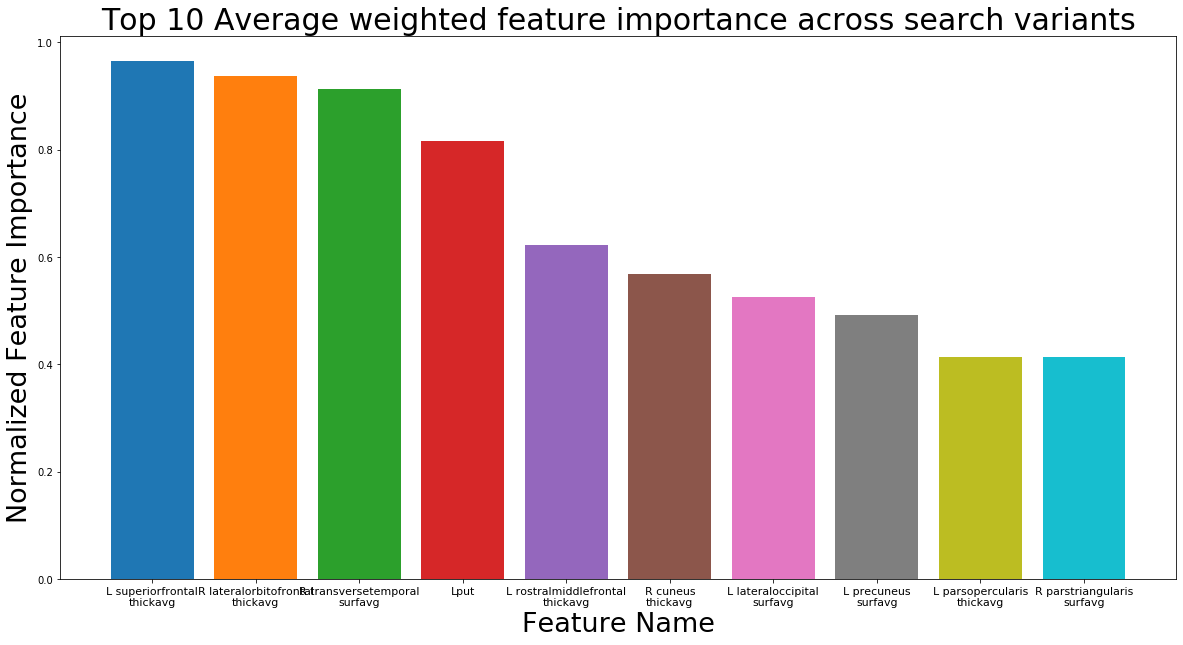

In [31]:
plot_feat_importance(fc, 'Top 10 Average weighted feature importance across search variants', 10, True)

In [32]:
import nibabel
import nilearn
from nilearn import datasets
from nilearn import plotting
import nibabel.freesurfer.io as io

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

In [33]:
save = dict(fc)

fc['L_putamen_volume'] = fc['Lput']
del fc['Lput']

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from Neuro_Shit.Plotting import *
import seaborn as sns
import matplotlib.gridspec as gridspec


import numpy as np
import matplotlib.pyplot as plt
import nilearn
import nilearn.plotting
import os
from matplotlib import cm
import nibabel.freesurfer.io as io
from nilearn import datasets
from Neuro_Shit.plot_surf import plot_surf, add_collage_colorbar
from nilearn.plotting.img_plotting import _crop_colorbar
import matplotlib.gridspec as gridspec

In [35]:
lh, rh, label_names, fs_avg = get_setup(fs_home='/mnt/sda5/freesurfer', # Your fs dr
                                        destr=False,  # This is the only option right now
                                        fs5=False) # Change to false for fsaverage
mapping = {}
for l in label_names:
    if l != 'unknown':
        mapping[l] = l
    
thick = {s:save[s] for s in save if 'thickavg' in s}
surf = {s:save[s] for s in save if 'surfavg' in s}

thick_surf = get_hemi_surfaces(thick, 'L_', 'R_', lh, rh, label_names, mapping)
surf_surf = get_hemi_surfaces(surf, 'L_', 'R_', lh, rh, label_names, mapping)

(<Figure size 432x288 with 1 Axes>,
 array([0.00179628, 0.00179628, 0.00179628, ..., 0.        , 0.        ,
        0.        ]))

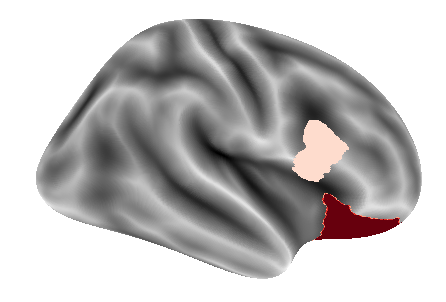

In [36]:
base_surf_plot(thick_surf[1], 'rh', True, fs_avg, dist=6, cmap='Reds', threshold=.1)

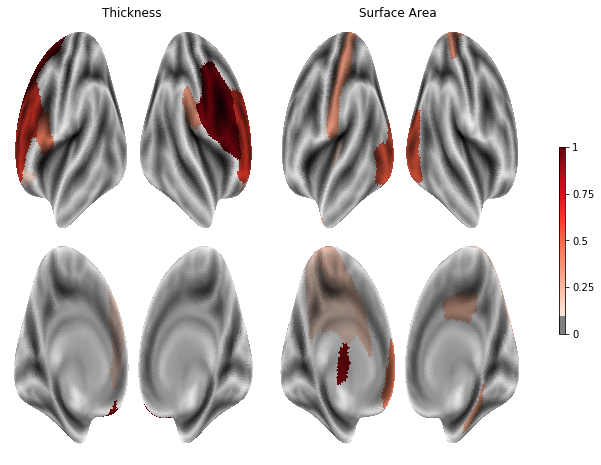

In [185]:
# You put in the grid you want to plot as... e.g., for 2x2
data = [[thick_surf, surf_surf]]

# Same w/ titles
titles = [['Thickness', 'Surface Area']]

# You can pass any of the base plotting params also
Collages(data,
         inflate=True,
         fs_avg=fs_avg,
         titles=titles,
         figsize=(10,8),
         outer_wspace=.1, # horizontal spacing between groups of 4 brain views
         outer_hspace=.1, # vertical spacing between groups of 4 brain views
         vmin=0, # If you leave these as None, it will set as the global min/max symmetric for all passed in surfs
         vmax=1,
         midpoint=None,
         threshold=.1,
         avg_method='median',
         cmap='Reds',
         darkness=1,
         alpha=1,
         bg_on_data=True,
         cbar_2_fig_ratio=.1, # Ratio between size of chunk of 4 brains w/ color bar
         cbar_fraction=1, # % of the colorbar box the colorbar should take-up
         cbar_shrink=1, # Scaling on the colorbar, so <1 makes it smaller, >1, bigger
         cbar_aspect=30) # Ratio of colorbar height to width


In [43]:
def Exp_Collages(all_data,
                 inflate,
                 fs_avg,
                 data_dict=None,
                 top=10,
                 titles=None,
                 figsize=(15, 10),
                 outer_wspace=.1,
                 outer_hspace=.1,
                 vmin=None,
                 vmax=None,
                 midpoint=None,
                 colorbar=True,
                 cbar_2_fig_ratio=.5,
                 bar_ratio=1,
                 cbar_fraction=.25,
                 cbar_shrink=1,
                 cbar_aspect=20,
                 cbar_pad=.1,
                 dist=6,
                 cmap='Reds',
                 **kwargs):
    '''Data as list of [lh, rh] lists. Must be 3 deep.
       Titles should be 2 nested list'''
    
    kwargs['cmap'] = cmap

    if vmin is None:
        vmin = np.nanmin(np.nanmin(all_data))
    if vmax is None:
        vmax = np.nanmax(np.nanmax(all_data))

        if np.abs(vmin) > vmax:
            vmax = np.abs(vmin)
        else:
            vmin = -vmax

    figure = plt.figure(figsize=figsize)

    n_rows = len(all_data)
    n_cols_by_row = [len(all_data[r]) for r in range(n_rows)]
    n_cols = max(n_cols_by_row)
    
    
    widths = [1 for i in range(n_cols)]

    if colorbar is True:
        widths += [cbar_2_fig_ratio]

    if data_dict is not None:
        widths = [bar_ratio] + widths

    outer_gs = gridspec.GridSpec(n_rows, len(widths),
                                 wspace=outer_wspace,
                                 hspace=outer_hspace,
                                 width_ratios=widths)
    
    if colorbar is True:
        colorbar_ax = figure.add_subplot(outer_gs[:, -1])
        colorbar_ax.set_axis_off()
        
    if data_dict is not None:
        barplot_ax = figure.add_subplot(outer_gs[:, 0])

    smfs = []

    for row in range(n_rows):
        for col in range(n_cols_by_row[row]):
            
            ss_col = col
            if data_dict is not None:
                ss_col = col + 1

            # This is fixed as collage of 4
            gs = gridspec.GridSpecFromSubplotSpec(2, 2,
                                                  subplot_spec=outer_gs[row,
                                                                        ss_col],
                                                  hspace=0, wspace=0)

            if titles is not None:
                title_ax = figure.add_subplot(outer_gs[row, ss_col])
                title_ax.set_title(titles[row][col])
                title_ax.set_axis_off()

            hemis = [['lh', 'rh'], ['lh', 'rh']]
            views = ['lateral', 'medial']
            data = all_data[row][col]

            for i in range(2):
                for j in range(2):
                    ax = figure.add_subplot(gs[i, j], projection='3d')

                    figure, smf = base_surf_plot(data[j], hemis[i][j], inflate,
                                                 fs_avg, figure=figure,
                                                 axes=ax, view=views[i],
                                                 vmin=vmin, vmax=vmax,
                                                 midpoint=midpoint, dist=6,
                                                 **kwargs)
                    smfs.append(smf)

    figure.subplots_adjust(hspace=0, wspace=0)

    if colorbar is True:
        add_collage_colorbar(figure=figure, ax=colorbar_ax, smfs=smfs,
                             vmax=vmax, vmin=vmin,
                             midpoint=midpoint,
                             multicollage=True,
                             cbar_shrink=cbar_shrink,
                             cbar_aspect=cbar_aspect,
                             cbar_pad=cbar_pad,
                             **kwargs)
        
    if data_dict is not None:
        
        data_dict = Counter(data_dict)
        top_x = data_dict.most_common(top)
        
        labels = [l[0] for l in top_x]
        values = [l[1] for l in top_x]
        
        labels = [l.replace('_', ' ') for l in labels]
        
        sns.barplot(x=values,
                    y=labels,
                    orientation='horizontal',
                    palette=cmap,
                    hue=values,
                    dodge=False,
                    ax=barplot_ax)
        
        barplot_ax.set_title('A. Top ' + str(top) + ' Features')
        barplot_ax.get_legend().remove()
        
        #barplot_ax.set_axisbelow(True)
        #barplot_ax.xaxis.grid()
        
        sns.despine(ax=barplot_ax, left=True, bottom=True)
        

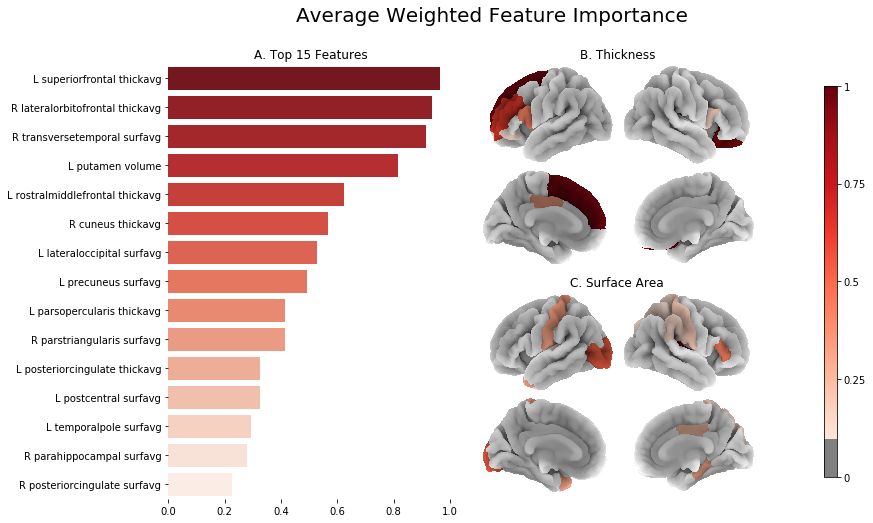

In [44]:
titles = [['B. Thickness'], ['C. Surface Area']]
data = [[thick_surf], [surf_surf]]

Exp_Collages(
         data,
         inflate=False,
         fs_avg=fs_avg,
         data_dict=fc,
         top=15,
         titles=titles,
         figsize=(12,8),
         outer_wspace=.1, # horizontal spacing between groups of 4 brain views
         outer_hspace=.1, # vertical spacing between groups of 4 brain views
         vmin=0, # If you leave these as None, it will set as the global min/max symmetric for all passed in surfs
         vmax=1,
         midpoint=None,
         threshold=.1,
         avg_method='median',
         cmap='Reds',
         darkness=1,
         alpha=1,
         bg_on_data=True,
         cbar_2_fig_ratio=.2,
         bar_ratio=1,
         cbar_fraction=.8, # % of the colorbar box the colorbar should take-up
         cbar_shrink=.9, # Scaling on the colorbar, so <1 makes it smaller, >1, bigger
         cbar_aspect=30)

plt.suptitle('Average Weighted Feature Importance', fontsize=20)
plt.savefig('Importance.tiff', dpi=500, bbox_inches='tight')

In [ ]:
fs_avg = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage')
lh = io.read_annot('/mnt/sda5/freesurfer/subjects/fsaverage/label/lh.aparc.annot')

surface = np.copy(lh[0])
label_names = [label.decode('UTF-8') for label in lh[2]]

for key in fc:
    if 'thickavg' in key and 'L_' in key:
        name = key.replace('L_', '').replace('_thickavg', '')
        
        ind = label_names.index(name)
        #print(ind, name, fc[key])
        surface = np.where(surface==ind, fc[key], surface)

surface = np.where(surface>=1, 0, surface)
surface = np.where(surface<0, 0, surface)


fig = plt.figure()
nilearn.plotting.plot_surf(fs_avg.infl_left, surf_map=surface, bg_map=fs_avg.sulc_left, hemi='left', cmap=cm.get_cmap('Reds'),
                threshold = .1, view='medial', avg_method='median', colorbar=True, symmetric_cbar=False, vmax=1, alpha=1,
                 bg_on_data=True, darkness=.75, title = 'Left Hemisphere Thickness Importance', figure=fig) #output_file='lh_thickness',
fig.savefig('LH_thick_medial.png', transparent=True, dpi=100)



fig = plt.figure()
nilearn.plotting.plot_surf(fs_avg.infl_left, surf_map=surface, bg_map=fs_avg.sulc_left, hemi='left', cmap=cm.get_cmap('Reds'),
                threshold = .1, view='lateral', avg_method='median', colorbar=True, symmetric_cbar=False, vmax=1, alpha=1,
                 bg_on_data=True, darkness=.75, title = 'Left Hemisphere Thickness Importance', figure=fig) #output_file='lh_thickness',
fig.savefig('LH_thick_lateral.png', transparent=True, dpi=100)

In [ ]:
fs_avg = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage')
lh = io.read_annot('/mnt/sda5/freesurfer/subjects/fsaverage/label/rh.aparc.annot')

surface = np.copy(lh[0])
label_names = [label.decode('UTF-8') for label in lh[2]]

for key in fc:
    if 'thickavg' in key and 'R_' in key:
        name = key.replace('R_', '').replace('_thickavg', '')
        
        ind = label_names.index(name)
        print(ind, name, fc[key])
        surface = np.where(surface==ind, fc[key], surface)

surface = np.where(surface>=1, 0, surface)
surface = np.where(surface<0, 0, surface)


fig = plt.figure()
nilearn.plotting.plot_surf(fs_avg.infl_right, surf_map=surface, bg_map=fs_avg.sulc_right, hemi='right', cmap=cm.get_cmap('Reds'),
                threshold = .1, view='medial', avg_method='median', colorbar=True, symmetric_cbar=False, vmax=1, alpha=1,
                 bg_on_data=True, darkness=.75, title = 'Right Hemisphere Thickness Importance', figure=fig) #output_file='lh_thickness',
fig.savefig('RH_thick_medial.png', transparent=True, dpi=100)



fig = plt.figure()
nilearn.plotting.plot_surf(fs_avg.infl_right, surf_map=surface, bg_map=fs_avg.sulc_right, hemi='right', cmap=cm.get_cmap('Reds'),
                threshold = .1, view='lateral', avg_method='median', colorbar=True, symmetric_cbar=False, vmax=1, alpha=1,
                 bg_on_data=True, darkness=.75, title = 'Right Hemisphere Thickness Importance', figure=fig) #output_file='lh_thickness',
fig.savefig('RH_thick_lateral.png', transparent=True, dpi=100)

In [ ]:
fs_avg = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage')
lh = io.read_annot('/mnt/sda5/freesurfer/subjects/fsaverage/label/lh.aparc.annot')

surface = np.copy(lh[0])
label_names = [label.decode('UTF-8') for label in lh[2]]

for key in fc:
    if '_surfavg' in key and 'L_' in key:
        name = key.replace('L_', '').replace('_surfavg', '')
        
        ind = label_names.index(name)
        #print(ind, name, fc[key])
        surface = np.where(surface==ind, fc[key], surface)

surface = np.where(surface>=1, 0, surface)
surface = np.where(surface<0, 0, surface)


fig = plt.figure()
nilearn.plotting.plot_surf(fs_avg.infl_left, surf_map=surface, bg_map=fs_avg.sulc_left, hemi='left', cmap=cm.get_cmap('Reds'),
                threshold = .1, view='medial', avg_method='median', colorbar=True, symmetric_cbar=False, vmax=1, alpha=1,
                 bg_on_data=True, darkness=.75, title = 'Left Hemisphere Surface Importance', figure=fig) #output_file='lh_thickness',
fig.savefig('LH_surf_medial.png', transparent=True, dpi=100)



fig = plt.figure()
nilearn.plotting.plot_surf(fs_avg.infl_left, surf_map=surface, bg_map=fs_avg.sulc_left, hemi='left', cmap=cm.get_cmap('Reds'),
                threshold = .1, view='lateral', avg_method='median', colorbar=True, symmetric_cbar=False, vmax=1, alpha=1,
                 bg_on_data=True, darkness=.75, title = 'Left Hemisphere Surface Importance', figure=fig) #output_file='lh_thickness',
fig.savefig('LH_surf_lateral.png', transparent=True, dpi=100)

In [ ]:
fs_avg = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage')
lh = io.read_annot('/mnt/sda5/freesurfer/subjects/fsaverage/label/rh.aparc.annot')

surface = np.copy(lh[0])
label_names = [label.decode('UTF-8') for label in lh[2]]

for key in fc:
    if 'surfavg' in key and 'R_' in key:
        name = key.replace('R_', '').replace('_surfavg', '')
        
        ind = label_names.index(name)
        print(ind, name, fc[key])
        surface = np.where(surface==ind, fc[key], surface)

surface = np.where(surface>=1, 0, surface)
surface = np.where(surface<0, 0, surface)


fig = plt.figure()
nilearn.plotting.plot_surf(fs_avg.infl_right, surf_map=surface, bg_map=fs_avg.sulc_right, hemi='right', cmap=cm.get_cmap('Reds'),
                threshold = .1, view='medial', avg_method='median', colorbar=True, symmetric_cbar=False, vmax=1, alpha=1,
                 bg_on_data=True, darkness=.75, title = 'Right Hemisphere Surface Importance', figure=fig) #output_file='lh_thickness',
fig.savefig('RH_surf_medial.png', transparent=True, dpi=100)



fig = plt.figure()
nilearn.plotting.plot_surf(fs_avg.infl_right, surf_map=surface, bg_map=fs_avg.sulc_right, hemi='right', cmap=cm.get_cmap('Reds'),
                threshold = .1, view='lateral', avg_method='median', colorbar=True, symmetric_cbar=False, vmax=1, alpha=1,
                 bg_on_data=True, darkness=.75, title = 'Right Hemisphere Surface Importance', figure=fig) #output_file='lh_thickness',
fig.savefig('RH_surf_lateral.png', transparent=True, dpi=100)